In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Logistic Regression
## Classification Using Linear Regression
Load your data.

In [3]:
from helpers import sample_data, load_data, standardize, de_standardize

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
Y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, x = sample_data(Y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(x)

Use `least_squares` to compute w, and visualize the results.

In [4]:
from least_squares import least_squares
from plots import visualization
from numpy.linalg import inv
from numpy import dot, log, exp, sum, mean, maximum, abs

In [5]:
def least_squares(y, tx):
    """calculate the least squares."""
    w = dot(dot(inv(dot(tx.T, tx)), tx.T), y)
    mse = 1/2 * mean((y - dot(tx, w))**2)
    return mse, w

In [6]:
def score(X, Y, w):
    """calculate accuracy"""
    X, mean_X, std_X = standardize(X)
    tX = np.c_[np.ones((Y.shape[0], 1)), X]
    Y_pred = dot(tX, w)
    Y_pred = (Y_pred > 0.5).astype(int)
    acc = (Y_pred == Y).astype(int).sum() / len(Y)
    print("Accuracy: ", acc)

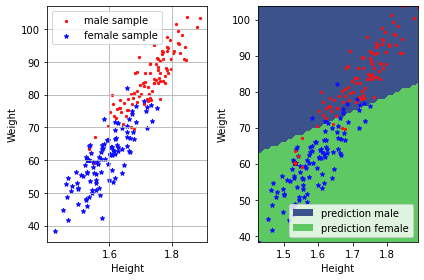

In [7]:
def least_square_classification_demo(y, x):
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    mse, w = least_squares(y, tx)

    visualization(y, x, mean_x, std_x, w, "classification_by_least_square")
    return w

w = least_square_classification_demo(y, x)

In [8]:
print(w)
score(X, Y, w)

[[ 0.51      ]
 [ 0.15239299]
 [-0.53847275]]
Accuracy:  0.9177


## Logistic Regression

Compute negative log likelihood loss.

In [9]:
def sigmoid(t):
    """apply the sigmoid function on t."""
    return 1 / (1 + exp(-t))

In [10]:
def calculate_loss(y, tx, w):
    """compute the loss: negative log likelihood."""
    # likelihood = -y * dot(tx, w) + log(1 + exp(dot(tx, w)))
    likelihood = maximum(tx.dot(w), 0) - y * tx.dot(w) + log(1 + exp(-abs(tx.dot(w))))

    return np.mean(likelihood)

In [11]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    gradient = np.zeros(w.shape[0])
    for x_, y_ in zip(tx, y):
        if dot(x_, w) < 0:
            p1 = exp(dot(x_, w)) / (1 + exp(dot(x_, w)))
        else:
            p1 = 1 / (1 + exp(-dot(x_, w)))
        gradient += x_ * (y_ - p1)
    return - np.reshape(gradient/len(y), (gradient.shape[0], 1))

### Using Gradient Descent
Implement your function to calculate the gradient for logistic regression.

In [12]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """

    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    w = w - gamma * gradient
    
    return loss, w

Demo!

Current iteration=0, loss=0.6931471805599452
Current iteration=100, loss=0.2353850246106184
Current iteration=200, loss=0.21739998548026016
Current iteration=300, loss=0.21072868133328648
Current iteration=400, loss=0.20775355549010843
Current iteration=500, loss=0.20628034832603726
Current iteration=600, loss=0.20550173565212704
Current iteration=700, loss=0.20507202551759754
Current iteration=800, loss=0.2048276333289461
Current iteration=900, loss=0.2046856092644491
Current iteration=1000, loss=0.20460175875190614
Current iteration=1100, loss=0.20455166599678576
Current iteration=1200, loss=0.20452147224858563
Current iteration=1300, loss=0.20450314852503262
Current iteration=1400, loss=0.20449197009113504
Current iteration=1500, loss=0.20448512305117902
Current iteration=1600, loss=0.2044809159140526
Current iteration=1700, loss=0.20447832453406342
Current iteration=1800, loss=0.2044767253306685
loss=0.20447619172919532


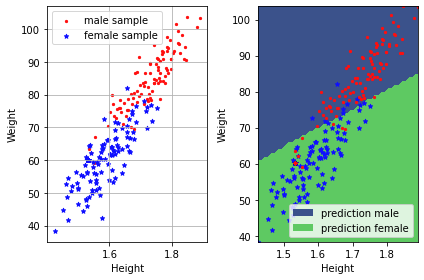

In [13]:
def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 1.
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent", True)
    print("loss={l}".format(l=calculate_loss(y, tx, w)))

    return w

w = logistic_regression_gradient_descent_demo(y, x)

In [14]:
print(w)
score(X, Y, w)

[[ 0.23693125]
 [ 2.44190879]
 [-6.95973276]]
Accuracy:  0.9166


Calculate your Hessian below

In [15]:
def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function."""
    hessian = np.zeros((w.shape[0], w.shape[0]))
    for x_, y_ in zip(tx, y):
        if dot(x_, w) < 0:
            p1 = exp(dot(x_, w)) / (1 + exp(dot(x_, w)))
        else:
            p1 = 1 / (1 + exp(-dot(x_, w)))
        hessian += np.reshape(x_, (x_.shape[0], 1)) * x_ * p1 * (1-p1)
    return hessian / len(y)

Write a function below to return loss, gradient, and Hessian.

In [16]:
def logistic_regression(y, tx, w):
    """return the loss, gradient, and Hessian."""
    loss = calculate_loss(y, tx, w)
    gradeint = calculate_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    return loss, gradeint, hessian

### Using Newton's method
Use Newton's method for logistic regression.

In [17]:
def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step on Newton's method. return the loss and updated w.
    """
    loss = calculate_loss(y, tx, w)
    w = w - gamma * dot(inv(calculate_hessian(y, tx, w)), calculate_gradient(y, tx, w))
    return loss, w

demo

Current iteration=0, the loss=0.6931471805599452
Current iteration=1, the loss=0.31705776869548
Current iteration=2, the loss=0.23652293099675328
Current iteration=3, the loss=0.20998733711242246
Current iteration=4, the loss=0.2047819931861897
Current iteration=5, the loss=0.20447559968244788
Current iteration=6, the loss=0.2044741280881354
Current iteration=7, the loss=0.20447412804945295
loss=0.20447412804945286


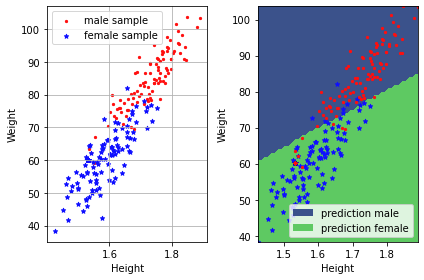

In [18]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    lambda_ = 0.1
    gamma = 1.
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_newton_method",True)
    print("loss={l}".format(l=calculate_loss(y, tx, w)))

    return w

w = logistic_regression_newton_method_demo(y, x)

In [19]:
print(w)
score(X, Y, w)

[[ 0.23840601]
 [ 2.46367002]
 [-6.9951691 ]]
Accuracy:  0.9166


### Using penalized logistic regression (first-order, no Newton)
Fill in the function below.

In [26]:
from numpy.linalg import norm

def calculate_penalized_loss(y, tx, w, lambda_):
    return calculate_loss(y, tx, w) + lambda_ / 2 * norm(w, 2)

In [27]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient"""
    loss = calculate_penalized_loss(y, tx, w, lambda_)
    gradient = calculate_gradient(y, tx, w) + lambda_ * w
    return loss, gradient

In [28]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    
    loss, gradient = penalized_logistic_regression(y, tx, w, lambda_)
    w = w - gamma * gradient

    return loss, w

Current iteration=0, loss=0.6931471805599452
Current iteration=100, loss=0.4101473126104731
Current iteration=200, loss=0.40558317581677883
Current iteration=300, loss=0.4049499475168889
Current iteration=400, loss=0.40479197936372685
Current iteration=500, loss=0.4047441003288671
Current iteration=600, loss=0.4047289417539044
Current iteration=700, loss=0.40472409958082767
loss=0.404722676044828


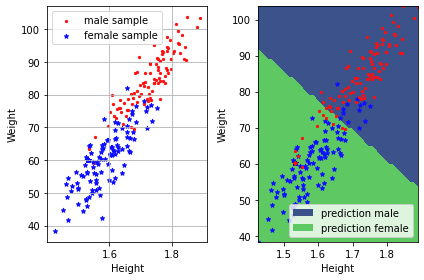

In [31]:
def logistic_regression_penalized_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    gamma = 0.1
    lambda_ = 0.1
    threshold = 1e-8
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalized_gradient_descent",True)
    print("loss={l}".format(l=calculate_penalized_loss(y, tx, w, lambda_)))
    
    return w

w = logistic_regression_penalized_gradient_descent_demo(y, x)

In [22]:
print(w)
score(X, Y, w)

[[ 0.03322979]
 [-0.59121482]
 [-1.06129773]]
Accuracy:  0.8655


In [23]:
norm(w, 2)

1.2153156163820298

Selecting different lambda

In [23]:
max_iter = 10000
gamma = 1.0
threshold = 1e-8
losses = []

# build tx
tx = np.c_[np.ones((y.shape[0], 1)), x]
w = np.zeros((tx.shape[1], 1))
W = []
lambda_all = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for lambda_ in lambda_all :
    print("######################")
    print("Lambda: ", lambda_)

    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)

        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break

    print("Loss: ", loss)
    score(X, Y, w)
    print("W: ", w.reshape(-1))
    print("W norm: ", norm(w, 2))
    W.append(w)

######################
Lambda:  0.0001
Loss:  0.20492909237840273
Accuracy:  0.9159
W:  [ 0.22829781  2.31855202 -6.75209892]
W norm:  7.142733594012653
######################
Lambda:  0.0005
Loss:  0.20769443609309698
Accuracy:  0.9156
W:  [ 0.19909597  1.8869798  -6.03718999]
W norm:  6.328348516455817
######################
Lambda:  0.001
Loss:  0.21185483062919364
Accuracy:  0.9139
W:  [ 0.17577632  1.52707681 -5.44947592]
W norm:  5.662124048819703
######################
Lambda:  0.005
Loss:  0.24049725003475428
Accuracy:  0.9059
W:  [ 0.10860024  0.39587336 -3.6222656 ]
W norm:  3.645451655605257
######################
Lambda:  0.01
Loss:  0.26400634774083614
Accuracy:  0.8996
W:  [ 0.083032   -0.06481004 -2.83568289]
W norm:  2.837638476282481
######################
Lambda:  0.05
Loss:  0.3480785737010025
Accuracy:  0.8771
W:  [ 0.04424535 -0.59832417 -1.45563717]
W norm:  1.574429749910782
######################
Lambda:  0.1
Loss:  0.40472181996437606
Accuracy:  0.8655
W:  [ 0.

In [24]:
def plot_lambda(x, y, W, lambda_all):

    fig = plt.figure(figsize=(20,15))
    x = de_standardize(x, mean_x, std_x)
    males = np.where(y == 0)
    females = np.where(y == 1)

    for i in range(len(lambda_all)):
        w = W[i]
        ax2 = fig.add_subplot(2, 4, i+1)
        ax2.title.set_text("lambda=%.4f" % lambda_all[i])

        height = np.arange(
            np.min(x[:, 0]), np.max(x[:, 0]) + 0.01, step=0.01)
        weight = np.arange(
            np.min(x[:, 1]), np.max(x[:, 1]) + 1, step=1)
        hx, hy = np.meshgrid(height, weight)
        hxy = (np.c_[hx.reshape(-1), hy.reshape(-1)] - mean_x) / std_x
        x_temp = np.c_[np.ones((hxy.shape[0], 1)), hxy]

        prediction = x_temp.dot(w) > 0.0
        prediction = prediction.reshape((weight.shape[0], height.shape[0]))    
        cs = ax2.contourf(hx, hy, prediction, 1)
        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
        for pc in cs.collections]
        
        ax2.scatter(
            x[females, 0], x[females, 1],
            marker='*', color=[0.06, 0.06, 1], s=20)
        ax2.scatter(
            x[males, 0], x[males, 1],
            marker='.', color=[1, 0.06, 0.06], s=20)
        ax2.set_xlabel("Height")
        ax2.set_ylabel("Weight")
        ax2.set_xlim([min(x[:, 0]), max(x[:, 0])])
        ax2.set_ylim([min(x[:, 1]), max(x[:, 1])])

    plt.savefig("l2.png")

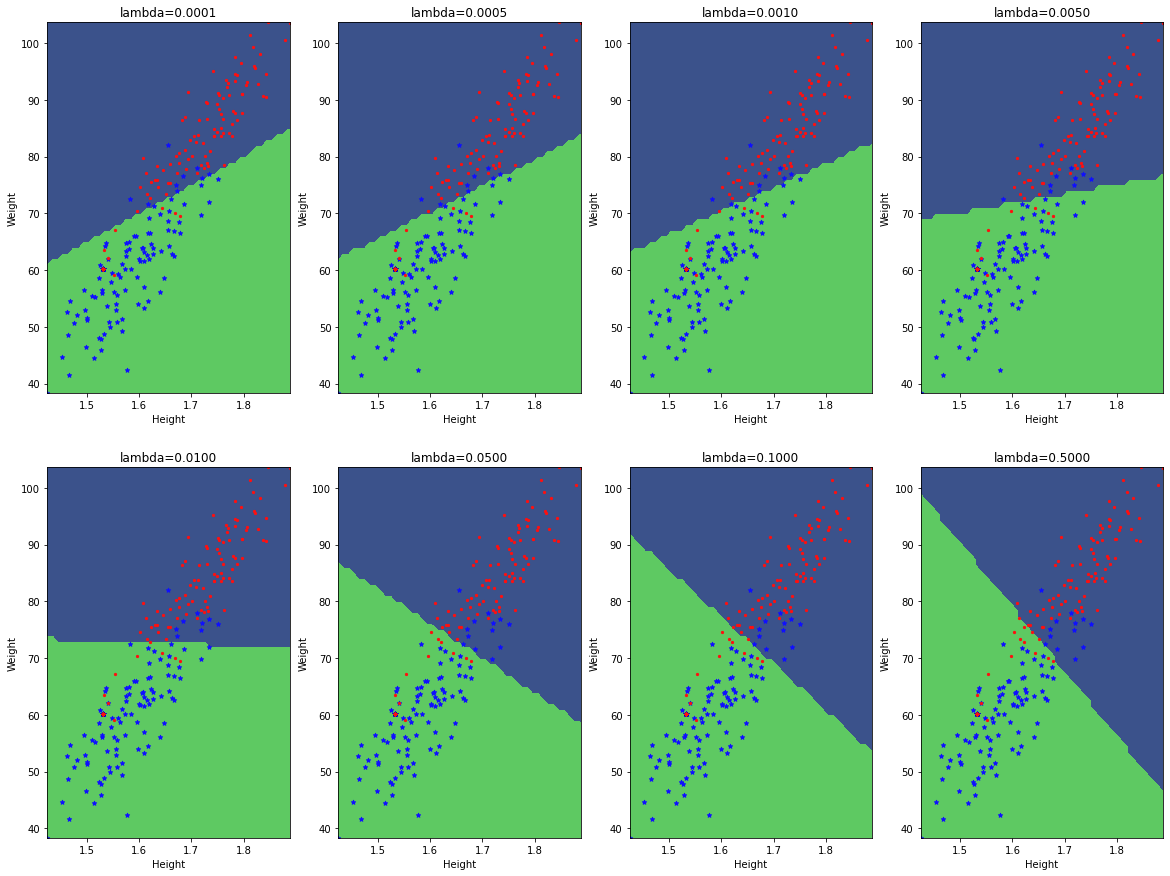

In [25]:
plot_lambda(x, y, W, lambda_all)